In [47]:
'''
MIT License
Copyright (c) 2019 Fanjin Zeng
This work is licensed under the terms of the MIT license, see <https://opensource.org/licenses/MIT>.  
'''

import numpy as np
from random import random
from collections import deque
from matplotlib import bezier, pyplot as plt
import scipy.interpolate as interpolate
from matplotlib import collections  as mc

FIELD_SIZE = (900, 600)

class Line():
    ''' Define line '''

    def __init__(self, p0, p1):
        self.p = np.array(p0)
        self.dirn = np.array(p1) - np.array(p0)
        self.dist = np.linalg.norm(self.dirn)
        self.dirn /= self.dist  # normalize

    def path(self, t):
        return self.p + t * self.dirn


def Intersection(line, center, radius):
    ''' Check line-sphere (circle) intersection '''
    a = np.dot(line.dirn, line.dirn)
    b = 2 * np.dot(line.dirn, line.p - center)
    c = np.dot(line.p - center, line.p - center) - radius * radius

    discriminant = b * b - 4 * a * c
    if discriminant < 0:
        return False

    t1 = (-b + np.sqrt(discriminant)) / (2 * a)
    t2 = (-b - np.sqrt(discriminant)) / (2 * a)

    if (t1 < 0 and t2 < 0) or (t1 > line.dist and t2 > line.dist):
        return False

    return True


def distance(x, y):
    return float(np.linalg.norm(np.array(x) - np.array(y)))


def isInObstacle(vex, obstacles, radius):
    for obs in obstacles:
        if distance(obs, vex) < radius:
            return True
    return False


def isThruObstacle(line, obstacles, radius):
    for obs in obstacles:
        if Intersection(line, obs, radius):
            return True
    return False


def nearest(G, vex, obstacles, radius):
    Nvex = None
    Nidx = None
    minDist = float("inf")

    for idx, v in enumerate(G.vertices):
        line = Line(v, vex)
        if isThruObstacle(line, obstacles, radius):
            continue

        dist = distance(v, vex)
        if dist < minDist:
            minDist = dist
            Nidx = idx
            Nvex = v

    return Nvex, Nidx


def newVertex(randvex, nearvex, stepSize):
    dirn = np.array(randvex) - np.array(nearvex)
    length = float(np.linalg.norm(dirn))
    dirn = (dirn / length) * min(stepSize, length)

    newvex = (nearvex[0]+dirn[0], nearvex[1]+dirn[1])
    return newvex


def window(startpos, endpos):
    ''' Define seach window - 2 times of start to end rectangle'''
    width = endpos[0] - startpos[0]
    height = endpos[1] - startpos[1]
    winx = startpos[0] - (width / 2.)
    winy = startpos[1] - (height / 2.)
    return winx, winy, width, height


def isInWindow(pos, winx, winy, width, height):
    ''' Restrict new vertex insides search window'''
    if winx < pos[0] < winx+width and \
            winy < pos[1] < winy+height:
        return True
    else:
        return False
    
def plot(G, obstacles, radius, path=None):
    '''
  Plot RRT, obstacles and shortest path
    '''
    px = [x for x, y in G.vertices]
    py = [y for x, y in G.vertices]
    fig, ax = plt.subplots()

    for obs in obstacles:
        circle = plt.Circle(obs, radius, color='red')
        ax.add_artist(circle)

    ax.scatter(px, py, c='cyan')
    ax.scatter(G.startpos[0], G.startpos[1], c='black')
    ax.scatter(G.endpos[0], G.endpos[1], c='black')

    lines = [(G.vertices[edge[0]], G.vertices[edge[1]]) for edge in G.edges]
    lc = mc.LineCollection(lines, colors='green', linewidths=2)
    ax.add_collection(lc)

    if path is not None:
        paths = [(path[i], path[i+1]) for i in range(len(path)-1)]
        lc2 = mc.LineCollection(paths, colors='blue', linewidths=3)
        ax.add_collection(lc2)

    ax.autoscale()
    ax.margins(0.1)

    ax.set_xlim(-450, 450)
    ax.set_ylim(-300, 300)
    plt.show()

#TODO: El radio está hardcodeado porsia, saludos sysmic del futuro: dani y riki
def isOutFieldLimit(vex,radius): #(vex, obstacles, radius)
    if  (vex[0] > FIELD_SIZE[0]/2 - 20 or vex[0] < -FIELD_SIZE[0]/2 + 20) or \
        (vex[1] > FIELD_SIZE[1]/2 - 20 or vex[1] < -FIELD_SIZE[1]/2 + 20):
        return True
    return False

class Graph:
    ''' Define graph '''

    def __init__(self, startpos, endpos):
        self.startpos = startpos
        self.endpos = endpos

        self.vertices = [startpos]
        self.edges = []
        self.success = False

        self.vex2idx = {startpos: 0}
        self.neighbors = {0: []}
        self.distances = {0: 0.}

        self.sx = endpos[0] - startpos[0]
        self.sy = endpos[1] - startpos[1]

    def add_vex(self, pos):
        try:
            idx = self.vex2idx[pos]
        except:
            idx = len(self.vertices)
            self.vertices.append(pos)
            self.vex2idx[pos] = idx
            self.neighbors[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2))
        self.neighbors[idx1].append((idx2, cost))
        self.neighbors[idx2].append((idx1, cost))

    def randomPosition(self):
        rdm = random()

        if rdm < 0.5: 
            rx = random()
            ry = random()
        else:
            rx = 1
            ry = 1

        posx = self.startpos[0] - (self.sx / 2.) + rx * self.sx * 2
        posy = self.startpos[1] - (self.sy / 2.) + ry * self.sy * 2
        return posx, posy

def RRT(startpos, endpos, obstacles, n_iter, radius, stepSize):
    ''' RRT algorithm '''
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        randvex = G.randomPosition()
        if isOutFieldLimit(randvex, radius):
            continue

        if isInObstacle(randvex, obstacles, radius):
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue

        newvex = newVertex(randvex, nearvex, stepSize)

        newidx = G.add_vex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)

        dist = distance(newvex, G.endpos)
        if dist < 2 * radius:
            endidx = G.add_vex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            G.success = True
            # print('success')
            # break
    return G


def RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize):
    ''' RRT star algorithm '''
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        randvex = G.randomPosition()
        if isOutFieldLimit(randvex, radius):
            continue

        if isInObstacle(randvex, obstacles, radius):
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue

        newvex = newVertex(randvex, nearvex, stepSize)

        newidx = G.add_vex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)
        G.distances[newidx] = G.distances[nearidx] + dist  # type: ignore

        # update nearby vertices distance (if shorter)
        for vex in G.vertices:
            if vex == newvex:
                continue

            dist = distance(vex, newvex)
            if dist > radius:
                continue

            line = Line(vex, newvex)
            if isThruObstacle(line, obstacles, radius):
                continue

            idx = G.vex2idx[vex]
            if G.distances[newidx] + dist < G.distances[idx]:
                G.add_edge(idx, newidx, dist)
                G.distances[idx] = G.distances[newidx] + dist

        dist = distance(newvex, G.endpos)
        if dist < 2 * radius:
            endidx = G.add_vex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            try:
                G.distances[endidx] = min(
                    G.distances[endidx], G.distances[newidx]+dist)
            except:
                G.distances[endidx] = G.distances[newidx]+dist

            G.success = True
            # print('success')
            # break
    return G


def dijkstra(G):
    '''
    Dijkstra algorithm for finding shortest path from start position to end.
    '''
    srcIdx = G.vex2idx[G.startpos]
    dstIdx = G.vex2idx[G.endpos]

    # build dijkstra
    nodes = list(G.neighbors.keys())
    dist = {node: float('inf') for node in nodes}
    prev = {node: None for node in nodes}
    dist[srcIdx] = 0

    while nodes:
        curNode = min(nodes, key=lambda node: dist[node])
        nodes.remove(curNode)
        if dist[curNode] == float('inf'):
            break

        for neighbor, cost in G.neighbors[curNode]:
            newCost = dist[curNode] + cost
            if newCost < dist[neighbor]:
                dist[neighbor] = newCost
                prev[neighbor] = curNode

    # retrieve path
    path = deque()
    curNode = dstIdx
    while prev[curNode] is not None:
        path.appendleft(G.vertices[curNode])
        curNode = prev[curNode]
    path.appendleft(G.vertices[curNode])
    return list(path)


def pathSearch(startpos, endpos, obstacles, n_iter, radius, stepSize):
    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    if G.success:
        path = dijkstra(G)
        return path

def smooth(path, resolution):
    # smooth path using derivates:

    # first derivative
    path_deriv = np.diff(path, axis=0)
    path_deriv = np.vstack((path_deriv, path_deriv[-1]))

    # second derivative
    path_deriv2 = np.diff(path_deriv, axis=0)
    path_deriv2 = np.vstack((path_deriv2, path_deriv2[-1]))

    # smooth path
    path_smooth = path + resolution*path_deriv + 0.5*resolution**2*path_deriv2

    return path_smooth

def smooth_path(path, smoothness, obstacles):
    # Convertir la lista de tuplas a un array NumPy
    path = np.array(path)

    # Generar los puntos de control para los B-splines
    t = np.linspace(0, 1, len(path))
    tck, u = interpolate.splprep([path[:, 0], path[:, 1]], s=smoothness)

    # Evaluar la curva suavizada utilizando B-splines
    smoothed_path = np.column_stack(interpolate.splev(u, tck))
    for obstacle in obstacles:
        x, y = obstacle
        dist = np.sqrt((smoothed_path[:, 0] - x)
                       ** 2 + (smoothed_path[:, 1] - y)**2)
        if np.any(dist < 0.5):  # Distancia mínima de separación
            return None  # Ruta inválida, retorna None

    return smoothed_path

def plot(G, obstacles, radius, path=None):
    '''
  Plot RRT, obstacles and shortest path
    '''
    px = [x for x, y in G.vertices]
    py = [y for x, y in G.vertices]
    fig, ax = plt.subplots()

    for obs in obstacles:
        circle = plt.Circle(obs, radius, color='red')
        ax.add_artist(circle)

    ax.scatter(px, py, c='cyan')
    ax.scatter(G.startpos[0], G.startpos[1], c='black')
    ax.scatter(G.endpos[0], G.endpos[1], c='black')

    lines = [(G.vertices[edge[0]], G.vertices[edge[1]]) for edge in G.edges]
    lc = mc.LineCollection(lines, colors='green', linewidths=2)
    ax.add_collection(lc)

    if path is not None:
        paths = [(path[i], path[i+1]) for i in range(len(path)-1)]
        lc2 = mc.LineCollection(paths, colors='blue', linewidths=3)
        ax.add_collection(lc2)

    ax.autoscale()
    ax.margins(0.1)
    plt.show()


F
[[-399.75185461  249.58931756]
 [-391.88436862  249.63775891]
 [-383.98907507  249.64220101]
 [-376.06835266  249.60694191]
 [-368.1245801   249.53627968]
 [-360.16013608  249.43451235]
 [-352.17739932  249.30593799]
 [-344.17874853  249.15485464]
 [-336.16656239  248.98556037]
 [-328.14321963  248.80235322]
 [-320.11109894  248.60953125]
 [-312.07257903  248.41139251]
 [-304.03003861  248.21223506]
 [-295.98585637  248.01635694]
 [-287.94241103  247.82805622]
 [-279.90208129  247.65163093]
 [-271.86724586  247.49137915]
 [-263.84028343  247.35159892]
 [-255.82357272  247.23658829]
 [-247.81949243  247.15064532]
 [-239.83042126  247.09806805]
 [-231.85873792  247.08315456]
 [-223.90682111  247.11020288]
 [-215.97780967  247.18406058]
 [-208.07788294  247.31177326]
 [-200.21398039  247.50093603]
 [-192.39304147  247.759144  ]
 [-184.62200567  248.09399228]
 [-176.90781245  248.51307598]
 [-169.25229666  249.01587272]
 [-161.6368747   249.56939015]
 [-154.03785834  250.13251844]
 [-146

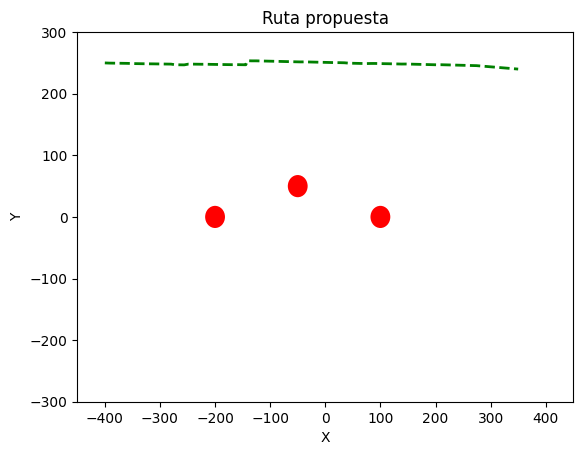

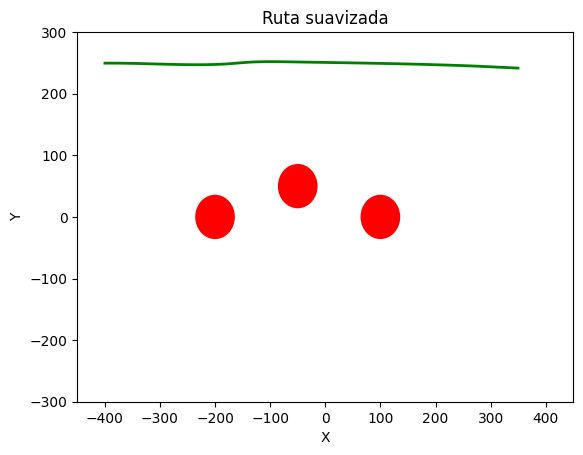

In [34]:
if __name__ == '__main__':
    startpos = (0., 0.)
    endpos = (-350., 100.)
    obstacles = [(100., 0.), (-50., 50.), (-200., 0.)]
    n_iter = 100
    radius = 18*2 + 2
    stepSize = 8

    # G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    G = RRT(startpos, endpos, obstacles, n_iter, radius, stepSize)

    if G.success:
        path = dijkstra(G)
        print(path)
    else:
        print("F")

    fig, ax = plt.subplots()

    # Graficar los obstáculos
    for obstacle in obstacles:
        circle = plt.Circle(obstacle, radius=18, fc='r')
        ax.add_patch(circle)

    # Graficar la ruta propuesta
    x_values = [point[0] for point in path]
    y_values = [point[1] for point in path]
    ax.plot(x_values, y_values, 'g--', linewidth=2)

    # Configurar los límites de los ejes
    ax.set_xlim(-450, 450)
    ax.set_ylim(-300, 300)

    # Configurar etiquetas
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Ruta propuesta')

    # Mostrar la figura
    plt.savefig('RRT_star.png')
    path_smooth = smooth_path(
        path, smoothness=len(path)-1, obstacles=obstacles)
    print(path_smooth)
    fig, ax = plt.subplots()

    # Graficar los obstáculos
    for obstacle in obstacles:
        circle = plt.Circle(obstacle, radius=18*2, fc='r')
        ax.add_patch(circle)

    # Graficar la ruta propuesta
    x_values = [point[0] for point in path_smooth]
    y_values = [point[1] for point in path_smooth]
    ax.plot(x_values, y_values, 'g', linewidth=2)

    # Configurar los límites de los ejes
    ax.set_xlim(-450, 450)
    ax.set_ylim(-300, 300)

    # Configurar etiquetas
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Ruta suavizada')

    # Mostrar la figura
    plt.savefig('RRT_star_smooth.png')

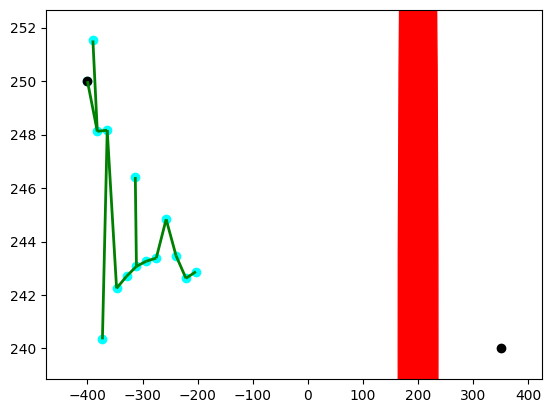

[[-399.75185461  249.58931756]
 [-391.88436862  249.63775891]
 [-383.98907507  249.64220101]
 [-376.06835266  249.60694191]
 [-368.1245801   249.53627968]
 [-360.16013608  249.43451235]
 [-352.17739932  249.30593799]
 [-344.17874853  249.15485464]
 [-336.16656239  248.98556037]
 [-328.14321963  248.80235322]
 [-320.11109894  248.60953125]
 [-312.07257903  248.41139251]
 [-304.03003861  248.21223506]
 [-295.98585637  248.01635694]
 [-287.94241103  247.82805622]
 [-279.90208129  247.65163093]
 [-271.86724586  247.49137915]
 [-263.84028343  247.35159892]
 [-255.82357272  247.23658829]
 [-247.81949243  247.15064532]
 [-239.83042126  247.09806805]
 [-231.85873792  247.08315456]
 [-223.90682111  247.11020288]
 [-215.97780967  247.18406058]
 [-208.07788294  247.31177326]
 [-200.21398039  247.50093603]
 [-192.39304147  247.759144  ]
 [-184.62200567  248.09399228]
 [-176.90781245  248.51307598]
 [-169.25229666  249.01587272]
 [-161.6368747   249.56939015]
 [-154.03785834  250.13251844]
 [-146.4

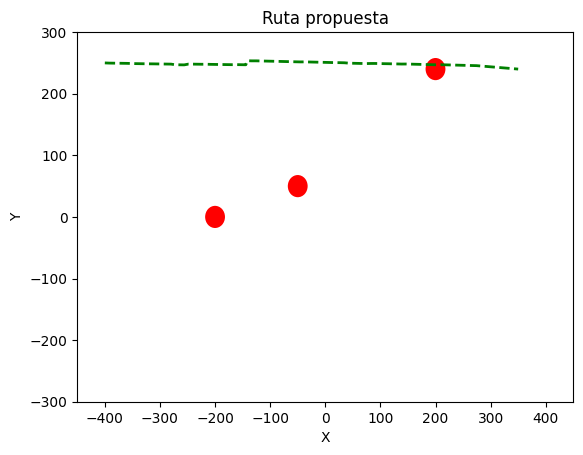

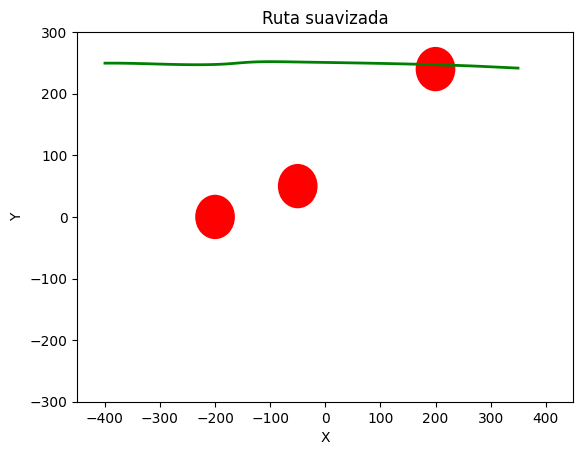

In [49]:
if __name__ == '__main__':
    startpos = (-400., 250.)
    endpos = (350., 240.)
    obstacles = [(-50., 50.), (-200., 0.)]
    n_iter = 100
    radius = 18*2
    stepSize = 18

    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    #G = RRT(startpos, endpos, obstacles, n_iter, radius, stepSize)

    if G.success:
        path = dijkstra(G)
        print(path)
    else:
        plot(G, obstacles, radius)

    fig, ax = plt.subplots()

    # Graficar los obstáculos
    for obstacle in obstacles:
        circle = plt.Circle(obstacle, radius=18, fc='r')
        ax.add_patch(circle)

    # Graficar la ruta propuesta
    x_values = [point[0] for point in path]
    y_values = [point[1] for point in path]
    ax.plot(x_values, y_values, 'g--', linewidth=2)

    # Configurar los límites de los ejes
    ax.set_xlim(-450, 450)
    ax.set_ylim(-300, 300)

    # Configurar etiquetas
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Ruta propuesta')

    # Mostrar la figura
    plt.savefig('RRT_star.png')
    path_smooth = smooth_path(
        path, smoothness=len(path)-1, obstacles=obstacles)
    print(path_smooth)
    fig, ax = plt.subplots()

    # Graficar los obstáculos
    for obstacle in obstacles:
        circle = plt.Circle(obstacle, radius=18*2, fc='r')
        ax.add_patch(circle)

    # Graficar la ruta propuesta
    x_values = [point[0] for point in path_smooth]
    y_values = [point[1] for point in path_smooth]
    ax.plot(x_values, y_values, 'g', linewidth=2)

    # Configurar los límites de los ejes
    ax.set_xlim(-450, 450)
    ax.set_ylim(-300, 300)

    # Configurar etiquetas
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Ruta suavizada')

    # Mostrar la figura
    plt.savefig('RRT_star_smooth.png')